In [1]:
import os
%pylab inline
import numpy as np
import hashlib

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [44]:
import os 
import hashlib
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.metrics import accuracy_score
import seaborn as sns 
from matplotlib.patches import Rectangle 

import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, BatchNormalization, Dropout, Softmax
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.losses import CategoricalCrossentropy
from qkeras.utils import _add_supported_quantized_objects
from tensorflow.keras.models import load_model
from qkeras.utils import _add_supported_quantized_objects

## Read training data

#### Impoartant! 
Download the dataset locally from [OneDrive here](https://purdue0-my.sharepoint.com/personal/du245_purdue_edu/_layouts/15/onedrive.aspx?id=%2Fpersonal%2Fdu245%5Fpurdue%5Fedu%2FDocuments%2FShared%2FQSC%20ML%20for%20readout%2FFinal%5Fraw%5Fdata%5Ffor%5Fpaper%2Fdata%5F0528%5Fnpy). We are using QICK data with timestamp **0528**. 

In [6]:
def one_hot_encode(data):
    y_encoded = np.zeros([data.shape[0],2], dtype=np.int32)
    for idx, x in enumerate(data):
        if x == 1:
            y_encoded[idx][1] = 1
        else:
            y_encoded[idx][0] = 1
    return y_encoded

In [7]:
train_data_dir = "../data/malab_05282024/npz/"
test_data_dir = "../data/malab_05282024/npz/"
start_window = 0
end_window = 770

In [8]:
"""Loadning training split"""
x_train_path = os.path.join(train_data_dir, f'0528_X_train_0_770.npy')
y_train_path = os.path.join(train_data_dir, f'0528_y_train_0_770.npy')

assert os.path.exists(x_train_path), f"ERROR: File {x_train_path} does not exist."
assert os.path.exists(y_train_path), f"ERROR: File {y_train_path} does not exist."

data_X = np.load(x_train_path)
data_Y = np.load(y_train_path)

# Insure same dataset is loaded 
assert hashlib.md5(data_X).hexdigest() == 'b61226c86b7dee0201a9158455e08ffb',  "Checksum failed. Wrong file was loaded or file may be corrupted."
assert hashlib.md5(data_Y).hexdigest() == 'c59ce37dc7c73d2d546e7ea180fa8d31',  "Checksum failed. Wrong file was loaded or file may be corrupted."

assert len(data_X[0]) == (end_window-start_window)*2, f"ERROR: X_test sample size {len(data_X[0])} does not match (start window, end window) ({start_window},{end_window}) size."


print("Train Data Set:")
print(f"  X Path : {x_train_path}")
print(f"  y Path : {y_train_path}")
print(f"  Size : {len(data_X):,}")
print(f"  Shape : {data_X[0].shape}")

Train Data Set:
  X Path : ../data/malab_05282024/npz/0528_X_train_0_770.npy
  y Path : ../data/malab_05282024/npz/0528_y_train_0_770.npy
  Size : 900,000
  Shape : (1540,)


## Reshape training data

In [9]:
# index = [file_index, state_index, shot_index, time_index, ADC_index]
data_X_new = data_X.reshape(90, 2, 5000, 770, 2)
data_Y_new = data_Y.reshape(90, 2, 5000)

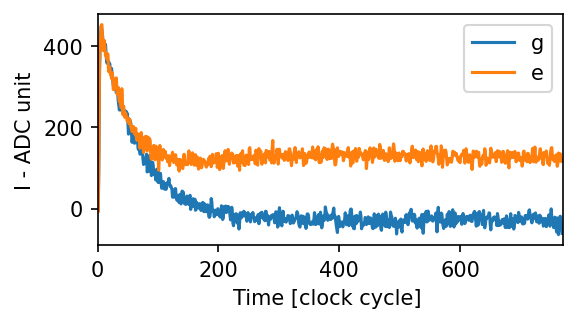

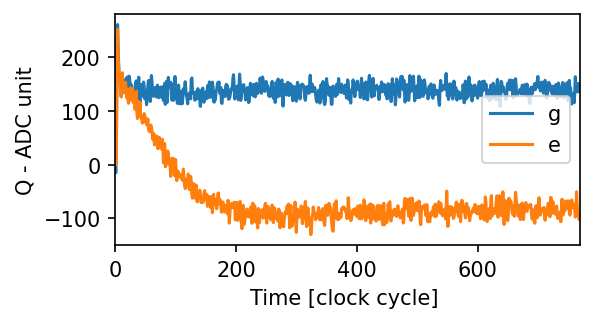

In [10]:
file_index = 0

#### I part ###
figure(figsize = (4,2), dpi = 150)


test = data_X_new[file_index,0].mean(axis = 0)
plot(test[:,0], label = 'g')
test = data_X_new[file_index,1].mean(axis = 0)
plot(test[:,0], label = 'e')
legend()

ylabel('I - ADC unit')
xlabel('Time [clock cycle] ')
xlim(0,770)
legend()
show()


#### Q part ###
figure(figsize = (4,2), dpi = 150)


test = data_X_new[file_index,0].mean(axis = 0)
plot(test[:,1], label = 'g')
test = data_X_new[file_index,1].mean(axis = 0)
plot(test[:,1], label = 'e')
legend()

ylabel('Q - ADC unit')
xlabel('Time [clock cycle] ')
xlim(0,770)
legend()
show()

## Read test data

#### Impoartant! 
Download the dataset locally from [OneDrive here](https://purdue0-my.sharepoint.com/personal/du245_purdue_edu/_layouts/15/onedrive.aspx?id=%2Fpersonal%2Fdu245%5Fpurdue%5Fedu%2FDocuments%2FShared%2FQSC%20ML%20for%20readout%2FFinal%5Fraw%5Fdata%5Ffor%5Fpaper%2Fdata%5F0528%5Fnpy). We are using QICK data with timestamp **0528**. 

In [11]:
"""Loading testing split"""
x_test_path = os.path.join(test_data_dir, f'0528_X_test_0_770.npy')
y_test_path = os.path.join(test_data_dir, f'0528_y_test_0_770.npy')

assert os.path.exists(x_test_path), f"ERROR: File {x_test_path} does not exist."
assert os.path.exists(y_test_path), f"ERROR: File {y_test_path} does not exist."

test_X = np.load(x_test_path)
test_Y = np.load(y_test_path)

# Insure same dataset is loaded 
assert hashlib.md5(test_X).hexdigest() == 'b7d85f42522a0a57e877422bc5947cde', "Checksum failed. Wrong file was loaded or file may be corrupted."
assert hashlib.md5(test_Y).hexdigest() == '8c9cce1821372380371ade5f0ccfd4a2', "Checksum failed. Wrong file was loaded or file may be corrupted."

assert len(test_X[0]) == (end_window-start_window)*2, f"ERROR: X_test sample size {len(test_X[0])} does not match (start window, end window) ({start_window},{end_window}) size."


print("Test Data Set:")
print(f"  X Path : {x_test_path}")
print(f"  y Path : {y_test_path}")
print(f"  Size : {len(test_X):,}" )
print(f"  Sample Shape : {test_X[0].shape}")

Test Data Set:
  X Path : ../data/malab_05282024/npz/0528_X_test_0_770.npy
  y Path : ../data/malab_05282024/npz/0528_y_test_0_770.npy
  Size : 100,000
  Sample Shape : (1540,)


## Reshape test data

In [12]:
# index = [file_index, state_index, shot_index, time_index, ADC_index]
test_X_new = test_X.reshape(10, 2, 5000, 770, 2)
test_Y_new = test_Y.reshape(10, 2, 5000)

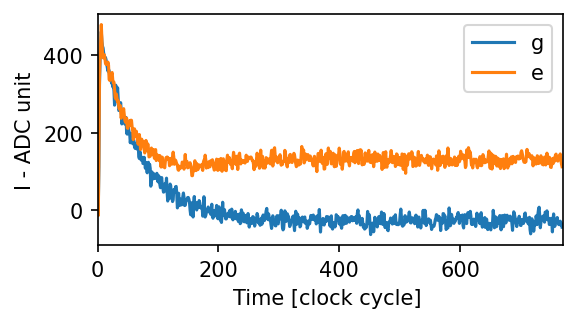

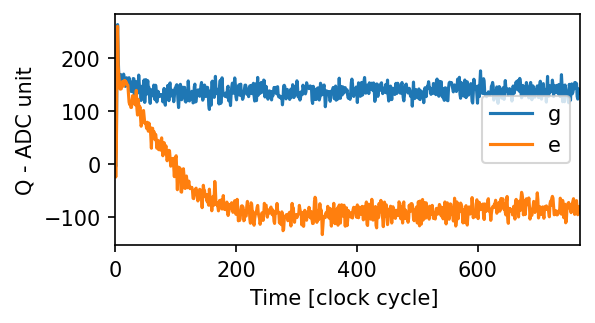

In [13]:
file_index = 0

#### I part ###
figure(figsize = (4,2), dpi = 150)


test = test_X_new[file_index,0].mean(axis = 0)
plot(test[:,0], label = 'g')
test = test_X_new[file_index,1].mean(axis = 0)
plot(test[:,0], label = 'e')
legend()

ylabel('I - ADC unit')
xlabel('Time [clock cycle] ')
xlim(0,770)
legend()
show()


#### Q part ###
figure(figsize = (4,2), dpi = 150)


test = test_X_new[file_index,0].mean(axis = 0)
plot(test[:,1], label = 'g')
test = test_X_new[file_index,1].mean(axis = 0)
plot(test[:,1], label = 'e')
legend()

ylabel('Q - ADC unit')
xlabel('Time [clock cycle] ')
xlim(0,770)
legend()
show()

## TH model

In [39]:
all_window_sizes = list(range(50, 701, 50)) + [770]
# all_window_sizes = list(range(50, 201, 50))
readout_loc_list = np.linspace(0,350, 8)
# all_fidelity = np.zeros(len(readout_loc_list))
all_fidelity = np.zeros([len(all_window_sizes), len(readout_loc_list)])
all_fidelity_train = np.zeros(len(readout_loc_list))

print('Readout Window Sizes', all_window_sizes)
print('Start Location', readout_loc_list)

Readout Window Sizes [50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 770]
Start Location [  0.  50. 100. 150. 200. 250. 300. 350.]


In [41]:
for i, window_size in enumerate(all_window_sizes):
    for m, readout_loc in enumerate(readout_loc_list):
        if readout_loc+window_size > 770:
            all_fidelity[i, m] = np.nan
            continue
        
        #### training data #####
        if True:
            mean_Ig_train = data_X_new[:, 0, :, int(readout_loc): int(readout_loc + window_size), 0].mean(axis = 2)
            mean_Qg_train = data_X_new[:, 0, :, int(readout_loc): int(readout_loc + window_size), 1].mean(axis = 2)
            mean_Ie_train = data_X_new[:, 1, :, int(readout_loc): int(readout_loc + window_size), 0].mean(axis = 2)
            mean_Qe_train = data_X_new[:, 1, :, int(readout_loc): int(readout_loc + window_size), 1].mean(axis = 2)

            # IQ plot
            I_g = mean_Ig_train.flatten()
            Q_g = mean_Qg_train.flatten()
            I_e = mean_Ie_train.flatten()
            Q_e = mean_Qe_train.flatten()

            # plt.title('IQ Plot')
            # plt.plot(I_g, Q_g, '.',label = 'g',markersize = 0.05)
            # plt.plot(I_e, Q_e, '.',label = 'e',markersize = 0.05)
            # plt.xlabel('I')
            # plt.ylabel('Q')
            # plt.legend()
            # plt.axis('square')
            # show()

            Ig = mean(I_g)
            Ie = mean(I_e)
            Qg = mean(Q_g)
            Qe = mean(Q_e)
            vec_I = Ie - Ig
            vec_Q = Qe - Qg

            gstate = (I_g - Ig)*vec_I + (Q_g - Qg)*vec_Q
            estate = (I_e - Ig)*vec_I + (Q_e - Qg)*vec_Q
            gstate = gstate / abs(vec_I+1j*vec_Q)**2
            estate = estate / abs(vec_I+1j*vec_Q)**2
            # plt.hist(gstate,bins = 300,label = 'g',alpha = 0.5)
            # plt.hist(estate,bins = 300,label = 'e',alpha = 0.5)
            # plt.legend()
            # show()

            th_min = min(gstate)
            th_max = max(estate)
            th_list = np.linspace(th_min,th_max,1000)

            fidelity = [(sum(gstate<th)+sum(estate>th))/np.shape(gstate)[0]/2 for i,th in enumerate(th_list)]
            print('max fidelity = ',max(fidelity)*2-1)
            loc_opt = argmax(fidelity)

            print('\n rough estimation of n_th')
            100*sum(gstate>th_list[argmax(fidelity)])/len(gstate)
            
            all_fidelity_train[m] = max(fidelity)*2-1
        
        #### testing data #####
        if True:
            mean_Ig_test = test_X_new[:, 0, :, int(readout_loc): int(readout_loc + window_size), 0].mean(axis = 2)
            mean_Qg_test = test_X_new[:, 0, :, int(readout_loc): int(readout_loc + window_size), 1].mean(axis = 2)
            mean_Ie_test = test_X_new[:, 1, :, int(readout_loc): int(readout_loc + window_size), 0].mean(axis = 2)
            mean_Qe_test = test_X_new[:, 1, :, int(readout_loc): int(readout_loc + window_size), 1].mean(axis = 2)

            # IQ plot
            I_g = mean_Ig_test.flatten()
            Q_g = mean_Qg_test.flatten()
            I_e = mean_Ie_test.flatten()
            Q_e = mean_Qe_test.flatten()
            
            gstate = (I_g - Ig)*vec_I + (Q_g - Qg)*vec_Q
            estate = (I_e - Ig)*vec_I + (Q_e - Qg)*vec_Q
            gstate = gstate / abs(vec_I+1j*vec_Q)**2
            estate = estate / abs(vec_I+1j*vec_Q)**2
            # plt.hist(gstate,bins = 300,label = 'g',alpha = 0.5)
            # plt.hist(estate,bins = 300,label = 'e',alpha = 0.5)
            # plt.legend()
            # show()
            
            th = th_list[loc_opt]
            test_fide = (sum(gstate<th)+sum(estate>th))/np.shape(gstate)[0]/2

            # all_fidelity[m] = test_fide*2-1
            all_fidelity[i, m] = test_fide*2-1

print('Train Fidelity', all_fidelity_train)
print('Test Fidelity', all_fidelity)

max fidelity =  0.0611600000000001

 rough estimation of n_th
max fidelity =  0.2956844444444444

 rough estimation of n_th
max fidelity =  0.4905911111111112

 rough estimation of n_th
max fidelity =  0.5950599999999999

 rough estimation of n_th
max fidelity =  0.6420777777777777

 rough estimation of n_th
max fidelity =  0.6580733333333333

 rough estimation of n_th
max fidelity =  0.6615622222222222

 rough estimation of n_th
max fidelity =  0.6604333333333334

 rough estimation of n_th
max fidelity =  0.25126000000000004

 rough estimation of n_th
max fidelity =  0.5333133333333333

 rough estimation of n_th
max fidelity =  0.6996933333333333

 rough estimation of n_th
max fidelity =  0.7698244444444444

 rough estimation of n_th
max fidelity =  0.795471111111111

 rough estimation of n_th
max fidelity =  0.8023311111111111

 rough estimation of n_th
max fidelity =  0.8009333333333333

 rough estimation of n_th
max fidelity =  0.7963733333333334

 rough estimation of n_th
max fide

In [70]:
checkpoint_dir = '../checkpoints/TH/'
outfile = '_TH_scan_window_size_and_location_window_size_0_770.npz'
note = f'Training data on 0528, readout fidelity with TH method, scanned window size and location'

np.savez(
    os.path.join(checkpoint_dir, outfile), 
    fidelity = all_fidelity, 
    all_window_start_locations=np.array(readout_loc_list),
    all_window_sizes=np.array(all_window_sizes),
    note=note
)

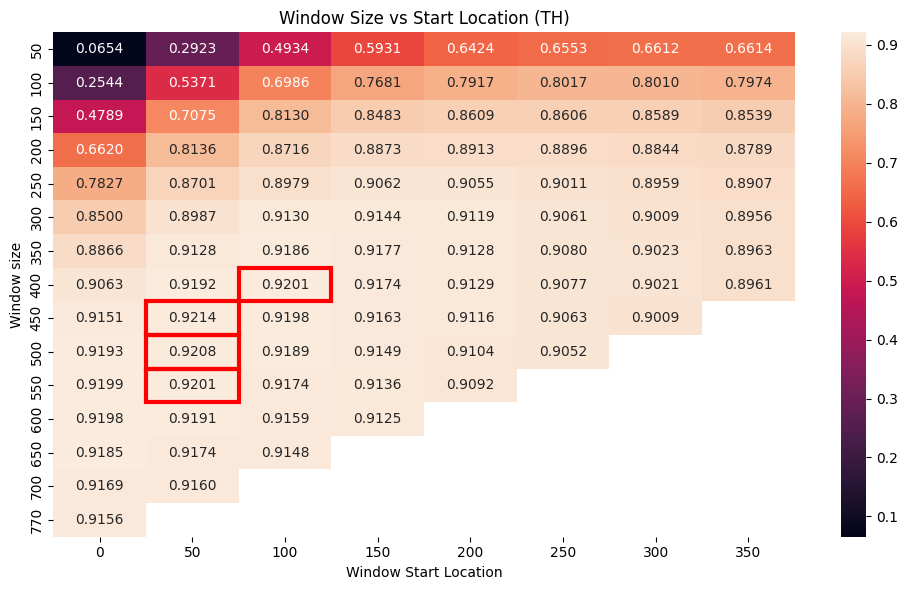

In [71]:
xi, yi = np.where(all_fidelity > 0.92)
readout_loc_list = [int(x) for x in readout_loc_list]

plt.figure(figsize=(10, 6))
ax = plt.gca()
sns.heatmap(all_fidelity, annot=True, fmt='.4f', mask=np.isnan(all_fidelity), yticklabels=all_window_sizes, xticklabels=readout_loc_list)
for i in range(len(xi)):
    ax.add_patch(Rectangle((yi[i], xi[i]), 1, height=1, fill=False, edgecolor='red', lw=3))
plt.title('Window Size vs Start Location (TH)')
plt.xlabel('Window Start Location')
plt.ylabel('Window size')
plt.tight_layout()
plt.savefig(os.path.join(checkpoint_dir, 'window_size_vs_start_all.png'))

## MF model

In [48]:
# index = [file_index, state_index, shot_index, time_index, ADC_index]
data_X_new = data_X.reshape(90, 2, 5000, 770, 2)
data_Y_new = data_Y.reshape(90, 2, 5000)

In [49]:
mean_Ig_trace = (data_X_new[:,0,:,:,0].mean(axis = 0)).mean(axis = 0)
mean_Qg_trace = (data_X_new[:,0,:,:,1].mean(axis = 0)).mean(axis = 0)
mean_Ie_trace = (data_X_new[:,1,:,:,0].mean(axis = 0)).mean(axis = 0)
mean_Qe_trace = (data_X_new[:,1,:,:,1].mean(axis = 0)).mean(axis = 0)

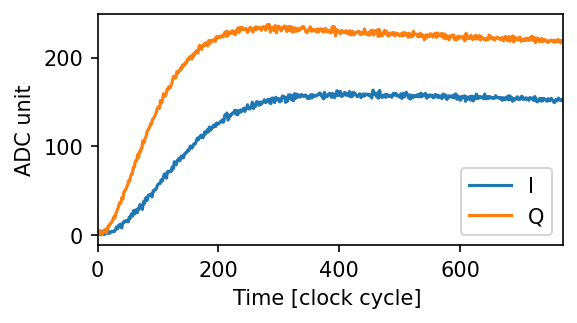

In [50]:
weight_I = abs(mean_Ig_trace - mean_Ie_trace)
weight_Q = abs(mean_Qg_trace - mean_Qe_trace)

figure(figsize = (4,2), dpi = 150)
plot(weight_I, label = 'I', color = 'C0', ls = '-')
plot(weight_Q, label = 'Q', color = 'C1', ls = '-')
ylabel('ADC unit')
xlabel('Time [clock cycle] ')
xlim(0,770)
legend()
show()

In [59]:
all_window_sizes = list(range(50, 701, 50)) + [770]
# all_window_sizes = list(range(50, 201, 50))
readout_loc_list = np.linspace(0,350, 8)

all_fidelity_MF_train = np.zeros([len(all_window_sizes), len(readout_loc_list)])
all_fidelity_MF_test = np.zeros([len(all_window_sizes), len(readout_loc_list)])

print('Readout Window Sizes', all_window_sizes)
print('Start Location', readout_loc_list)

Readout Window Sizes [50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 770]
Start Location [  0.  50. 100. 150. 200. 250. 300. 350.]


In [60]:
for i, window_size in enumerate(all_window_sizes):
    for m, readout_loc in enumerate(readout_loc_list):
        if readout_loc+window_size > 770:
            all_fidelity_MF_test[i, m] = np.nan
            continue
        #### training data #####
        if True:
            mean_Ig_train = data_X_new[:, 0, :, int(readout_loc): int(readout_loc + window_size), 0].dot(weight_I[int(readout_loc):int(readout_loc + window_size)])
            mean_Qg_train = data_X_new[:, 0, :, int(readout_loc): int(readout_loc + window_size), 1].dot(weight_Q[int(readout_loc):int(readout_loc + window_size)])
            mean_Ie_train = data_X_new[:, 1, :, int(readout_loc): int(readout_loc + window_size), 0].dot(weight_I[int(readout_loc):int(readout_loc + window_size)])
            mean_Qe_train = data_X_new[:, 1, :, int(readout_loc): int(readout_loc + window_size), 1].dot(weight_Q[int(readout_loc):int(readout_loc + window_size)])

            # IQ plot  
            ratio = 1.5
            I_g = ratio*mean_Ig_train.flatten()/770/2048
            Q_g = mean_Qg_train.flatten()/770/2048
            I_e = ratio*mean_Ie_train.flatten()/770/2048
            Q_e = mean_Qe_train.flatten()/770/2048

            # plt.title('IQ Plot')
            # plt.plot(I_g, Q_g, '.',label = 'g',markersize = 0.05)
            # plt.plot(I_e, Q_e, '.',label = 'e',markersize = 0.05)
            # plt.xlabel('I')
            # plt.ylabel('Q')
            # plt.legend()
            # plt.axis('square')
            # show()

            Ig = mean(I_g)
            Ie = mean(I_e)
            Qg = mean(Q_g)
            Qe = mean(Q_e)
            vec_I = Ie - Ig
            vec_Q = Qe - Qg

            gstate = (I_g - Ig)*vec_I + (Q_g - Qg)*vec_Q
            estate = (I_e - Ig)*vec_I + (Q_e - Qg)*vec_Q
            gstate = gstate / abs(vec_I+1j*vec_Q)**2
            estate = estate / abs(vec_I+1j*vec_Q)**2
            # plt.hist(gstate,bins = 300,label = 'g',alpha = 0.5)
            # plt.hist(estate,bins = 300,label = 'e',alpha = 0.5)
            # plt.legend()
            # show()

            th_min = min(gstate)
            th_max = max(estate)
            th_list = np.linspace(th_min,th_max,1000)

            fidelity = [(sum(gstate<th)+sum(estate>th))/np.shape(gstate)[0]/2 for i,th in enumerate(th_list)]
            print('max fidelity = ',max(fidelity)*2-1)
            loc_opt = argmax(fidelity)

            print('\n rough estimation of n_th')
            100*sum(gstate>th_list[argmax(fidelity)])/len(gstate)
            
            all_fidelity_MF_train[i,m] = max(fidelity)*2-1
        
        #### testing data #####
        if True:
            mean_Ig_test = test_X_new[:, 0, :, int(readout_loc): int(readout_loc + window_size), 0].dot(weight_I[int(readout_loc):int(readout_loc + window_size)])
            mean_Qg_test = test_X_new[:, 0, :, int(readout_loc): int(readout_loc + window_size), 1].dot(weight_Q[int(readout_loc):int(readout_loc + window_size)])
            mean_Ie_test = test_X_new[:, 1, :, int(readout_loc): int(readout_loc + window_size), 0].dot(weight_I[int(readout_loc):int(readout_loc + window_size)])
            mean_Qe_test = test_X_new[:, 1, :, int(readout_loc): int(readout_loc + window_size), 1].dot(weight_Q[int(readout_loc):int(readout_loc + window_size)])

            # IQ plot
            ratio = 1.5
            I_g = ratio*mean_Ig_test.flatten()/770/2048
            Q_g = mean_Qg_test.flatten()/770/2048
            I_e = ratio*mean_Ie_test.flatten()/770/2048
            Q_e = mean_Qe_test.flatten()/770/2048
            
            gstate = (I_g - Ig)*vec_I + (Q_g - Qg)*vec_Q
            estate = (I_e - Ig)*vec_I + (Q_e - Qg)*vec_Q
            gstate = gstate / abs(vec_I+1j*vec_Q)**2
            estate = estate / abs(vec_I+1j*vec_Q)**2
            # plt.hist(gstate,bins = 300,label = 'g',alpha = 0.5)
            # plt.hist(estate,bins = 300,label = 'e',alpha = 0.5)
            # plt.legend()
            # show()
            
            th = th_list[loc_opt]
            test_fide = (sum(gstate<th)+sum(estate>th))/np.shape(gstate)[0]/2

            all_fidelity_MF_test[i, m] = test_fide*2-1

max fidelity =  0.0781022222222223

 rough estimation of n_th
max fidelity =  0.2949488888888889

 rough estimation of n_th
max fidelity =  0.4825555555555556

 rough estimation of n_th
max fidelity =  0.5889711111111111

 rough estimation of n_th
max fidelity =  0.6399333333333332

 rough estimation of n_th
max fidelity =  0.6580177777777778

 rough estimation of n_th
max fidelity =  0.6616266666666666

 rough estimation of n_th
max fidelity =  0.6605244444444445

 rough estimation of n_th
max fidelity =  0.30351111111111106

 rough estimation of n_th
max fidelity =  0.542888888888889

 rough estimation of n_th
max fidelity =  0.6962666666666666

 rough estimation of n_th
max fidelity =  0.7673222222222222

 rough estimation of n_th
max fidelity =  0.7947266666666666

 rough estimation of n_th
max fidelity =  0.8022044444444445

 rough estimation of n_th
max fidelity =  0.8009288888888888

 rough estimation of n_th
max fidelity =  0.7961911111111111

 rough estimation of n_th
max fide

In [67]:
checkpoint_dir = '../checkpoints/MF/'
outfile = '_MF_scan_window_size_and_location_window_size_0_770.npz'
note = f'Training data on 0528, readout fidelity with MF method, scanned window size and location'

np.savez(
    os.path.join(checkpoint_dir, outfile), 
    fidelity = all_fidelity_MF_test, 
    fidelity_train = all_fidelity_MF_train, 
    all_window_start_locations=np.array(readout_loc_list),
    all_window_sizes=np.array(all_window_sizes),
    note=note
)

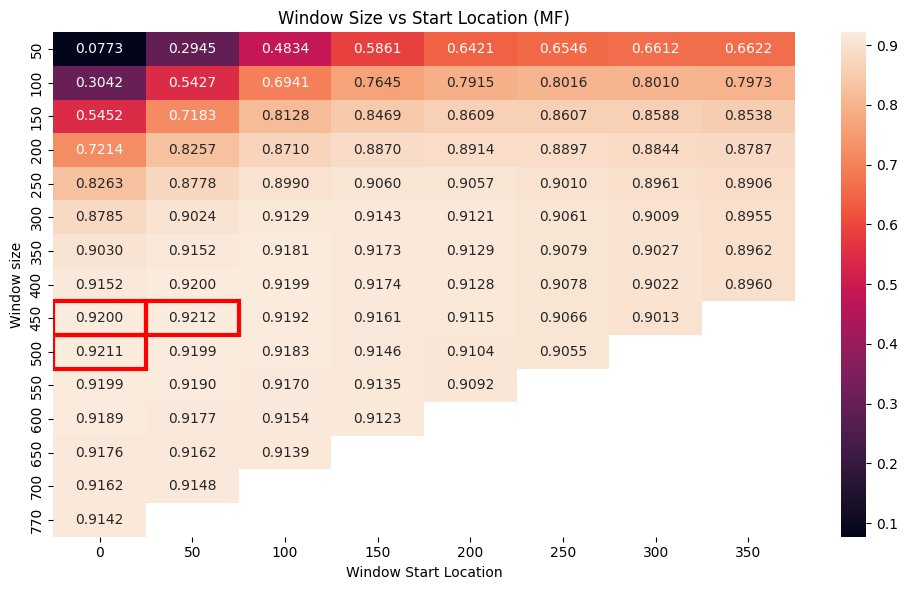

In [69]:
xi, yi = np.where(all_fidelity_MF_test > 0.92)
readout_loc_list = [int(x) for x in readout_loc_list]

plt.figure(figsize=(10, 6))
ax = plt.gca()
sns.heatmap(all_fidelity_MF_test, annot=True, fmt='.4f', mask=np.isnan(all_fidelity_MF_test), yticklabels=all_window_sizes, xticklabels=readout_loc_list)
for i in range(len(xi)):
    ax.add_patch(Rectangle((yi[i], xi[i]), 1, height=1, fill=False, edgecolor='red', lw=3))
plt.title('Window Size vs Start Location (MF)')
plt.xlabel('Window Start Location')
plt.ylabel('Window size')
plt.tight_layout()
plt.savefig(os.path.join(checkpoint_dir, 'window_size_vs_start_all.png'))